In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import logging

# Statistical analysis
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss

from statsmodels.tsa.api import ExponentialSmoothing, Holt, SimpleExpSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
# Machine learning metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from solar_prediction.sarima import determine_seasonality, prepare_time_series_data, check_stationarity, plot_acf_pacf_analysis, fit_sarima_model, auto_sarima_selection, perform_residual_diagnostics, fit_ets_model, select_best_ets_model, create_baseline_models, calculate_metrics, create_metrics_summary, diebold_mariano_test, plot_forecast_comparison, plot_error_analysis, create_performance_summary_plots

# Optional: Auto ARIMA (install with: pip install pmdarima)
try:
    from pmdarima import auto_arima
    AUTO_ARIMA_AVAILABLE = True
except ImportError:
    AUTO_ARIMA_AVAILABLE = False
    print("pmdarima not available. Manual SARIMA parameter selection will be used.")

# Configure settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Load dataset with automatic fallback to sample data
import sys
sys.path.append('../')
from solar_prediction.data_loader import load_solar_dataset, get_dataset_info

# Check available datasets
dataset_info = get_dataset_info()
print('Available datasets:')
for name, info in dataset_info.items():
    if info['exists']:
        print(f'  {name}: {info["records"]} records ({info["size_mb"]} MB)')
    else:
        print(f'  {name}: Not found')

# Load the dataset (will use full dataset if available, otherwise sample)
df_raw = load_solar_dataset()
print(f'\nLoaded dataset with {len(df_raw)} records')

print("Dataset Overview:")
print(f"Shape: {df_raw.shape}")
print(f"Columns: {list(df_raw.columns)}")
print("\nFirst few rows:")
df_raw.head()

print(f"\nTime Column Analysis:")
if 'Time' in df_raw.columns:
    df_raw['Time'] = pd.to_datetime(df_raw['Time'])
    time_diffs = df_raw['Time'].diff().dropna()
    print(f"Time differences (first 10): {time_diffs.head(10)}")
    print(f"Most common time difference: {time_diffs.mode().iloc[0] if len(time_diffs.mode()) > 0 else 'N/A'}")
    
    # Confirm 15-minute intervals
    if time_diffs.mode().iloc[0] == pd.Timedelta('15 minutes'):
        print("Confirmed: Data has 15-minute intervals")
    else:
        print(f"Unexpected interval: {time_diffs.mode().iloc[0]}")
else:
    print("'Time' column not found")

# Data info
print("Data Info:")
df_raw.info()

# Basic statistics
print("Descriptive Statistics:")
df_raw.describe()

2025-07-04 13:09:12,156 - INFO - Loading full dataset from: /Users/tom/workspace/github.com/itxtx/solar_prediction/notebooks/../data/solar_weather.csv
2025-07-04 13:09:12,298 - INFO - Successfully loaded full dataset with 196776 records


Available datasets:
  full_dataset: 196776 records (14.22 MB)
  sample_dataset: 1856 records (0.16 MB)

Loaded dataset with 196776 records
Dataset Overview:
Shape: (196776, 17)
Columns: ['Time', 'Energy delta[Wh]', 'GHI', 'temp', 'pressure', 'humidity', 'wind_speed', 'rain_1h', 'snow_1h', 'clouds_all', 'isSun', 'sunlightTime', 'dayLength', 'SunlightTime/daylength', 'weather_type', 'hour', 'month']

First few rows:

Time Column Analysis:
Time differences (first 10): 1    0 days 00:15:00
2    0 days 00:15:00
3    0 days 00:15:00
4    0 days 00:15:00
5    0 days 00:15:00
6    0 days 00:15:00
7    0 days 00:15:00
8    0 days 00:15:00
9    0 days 00:15:00
10   0 days 00:15:00
Name: Time, dtype: timedelta64[ns]
Most common time difference: 0 days 00:15:00
Confirmed: Data has 15-minute intervals
Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196776 entries, 0 to 196775
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------      

,Time,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,isSun,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month
count,196776,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000
mean,2019-10-29 22:44:12.085620992,573.008228,32.596538,9.790521,1015.292780,79.810566,3.937746,0.066035,0.007148,65.974387,0.519962,211.721094,748.644347,0.265187,3.198398,11.498902,6.298329
min,2017-01-01 00:00:00,0.000000,0.000000,-16.600000,977.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,450.000000,0.000000,1.000000,0.000000,1.000000
25%,2018-06-02 10:26:15,0.000000,0.000000,3.600000,1010.000000,70.000000,2.600000,0.000000,0.000000,34.000000,0.000000,0.000000,570.000000,0.000000,2.000000,5.000000,3.000000
50%,2019-10-28 20:52:30,0.000000,1.600000,9.300000,1016.000000,84.000000,3.700000,0.000000,0.000000,82.000000,1.000000,30.000000,765.000000,0.050000,4.000000,11.000000,6.000000
75%,2021-03-24 07:18:45,577.000000,46.800000,15.700000,1021.000000,92.000000,5.000000,0.000000,0.000000,100.000000,1.000000,390.000000,930.000000,0.530000,4.000000,17.000000,9.000000
max,2022-08-31 17:45:00,5020.000000,229.200000,35.800000,1047.000000,100.000000,14.300000,8.090000,2.820000,100.000000,1.000000,1020.000000,1020.000000,1.000000,5.000000,23.000000,12.000000
std,NaN,1044.824047,52.172018,7.995428,9.585773,15.604459,1.821694,0.278913,0.069710,36.628593,0.499603,273.902186,194.870208,0.329023,1.289939,6.921887,3.376066


In [ ]:


# Prepare the data
train_series, test_series, seasonality = prepare_time_series_data(
    df_raw, 
    time_col='Time', 
    target_col='GHI',
    test_size=0.2
)

Missing values before cleaning: 0
Missing values after cleaning: 0
Successfully set frequency to 15T (15-minute intervals)
Data prepared successfully:
   Total samples: 10480
   Training samples: 8384
   Test samples: 2096
   Seasonality period: 96
   Data frequency: <15 * Minutes>


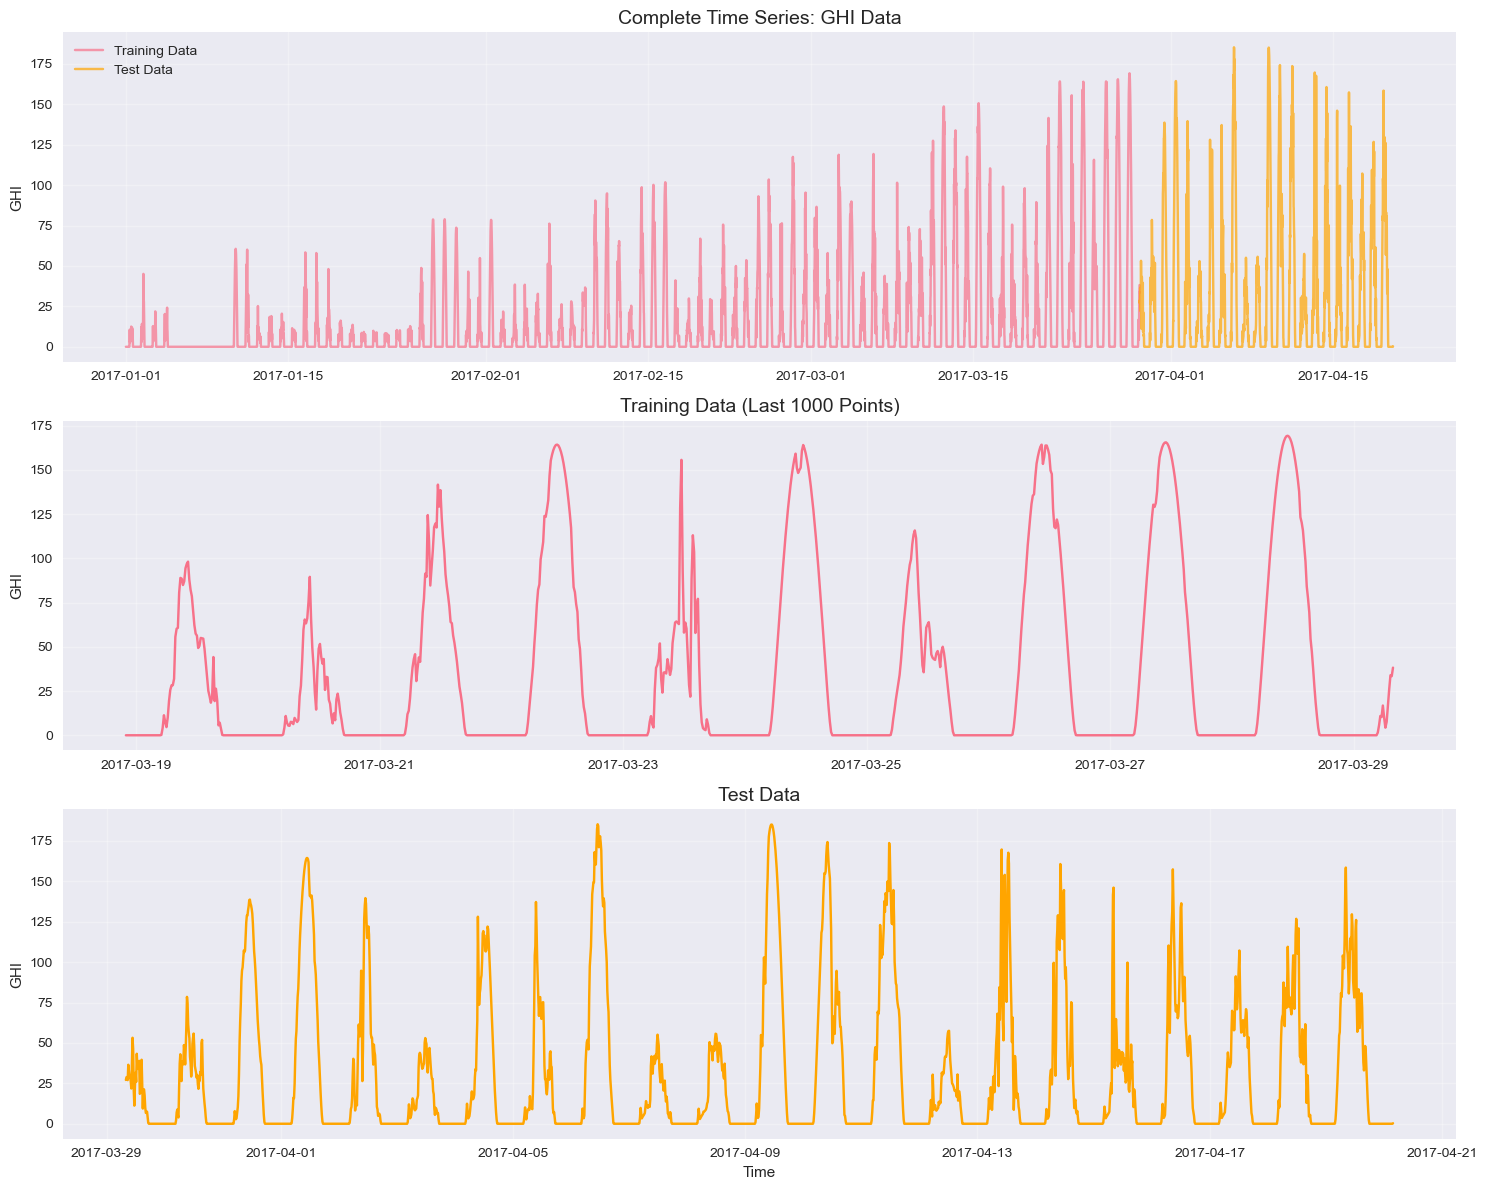

In [5]:
# Plot the full time series
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Full series
axes[0].plot(train_series.index, train_series, alpha=0.7, label='Training Data')
axes[0].plot(test_series.index, test_series, alpha=0.7, label='Test Data', color='orange')
axes[0].set_title('Complete Time Series: GHI Data', fontsize=14)
axes[0].set_ylabel('GHI')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Training data detail
axes[1].plot(train_series.index[-1000:], train_series[-1000:])
axes[1].set_title('Training Data (Last 1000 Points)', fontsize=14)
axes[1].set_ylabel('GHI')
axes[1].grid(True, alpha=0.3)

# Test data detail
axes[2].plot(test_series.index, test_series, color='orange')
axes[2].set_title('Test Data', fontsize=14)
axes[2].set_ylabel('GHI')
axes[2].set_xlabel('Time')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

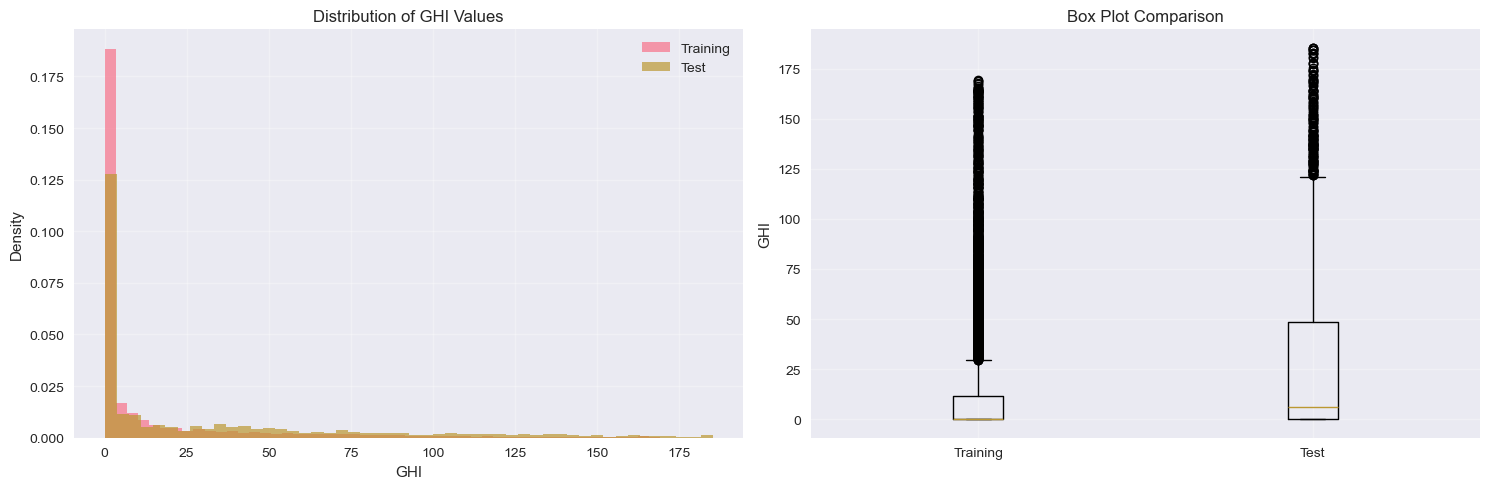

In [6]:
# Distribution analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(train_series, bins=50, alpha=0.7, density=True, label='Training')
axes[0].hist(test_series, bins=50, alpha=0.7, density=True, label='Test')
axes[0].set_title('Distribution of GHI Values')
axes[0].set_xlabel('GHI')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot comparison
data_for_box = [train_series.values, test_series.values]
axes[1].boxplot(data_for_box, labels=['Training', 'Test'])
axes[1].set_title('Box Plot Comparison')
axes[1].set_ylabel('GHI')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Performing seasonal decomposition...


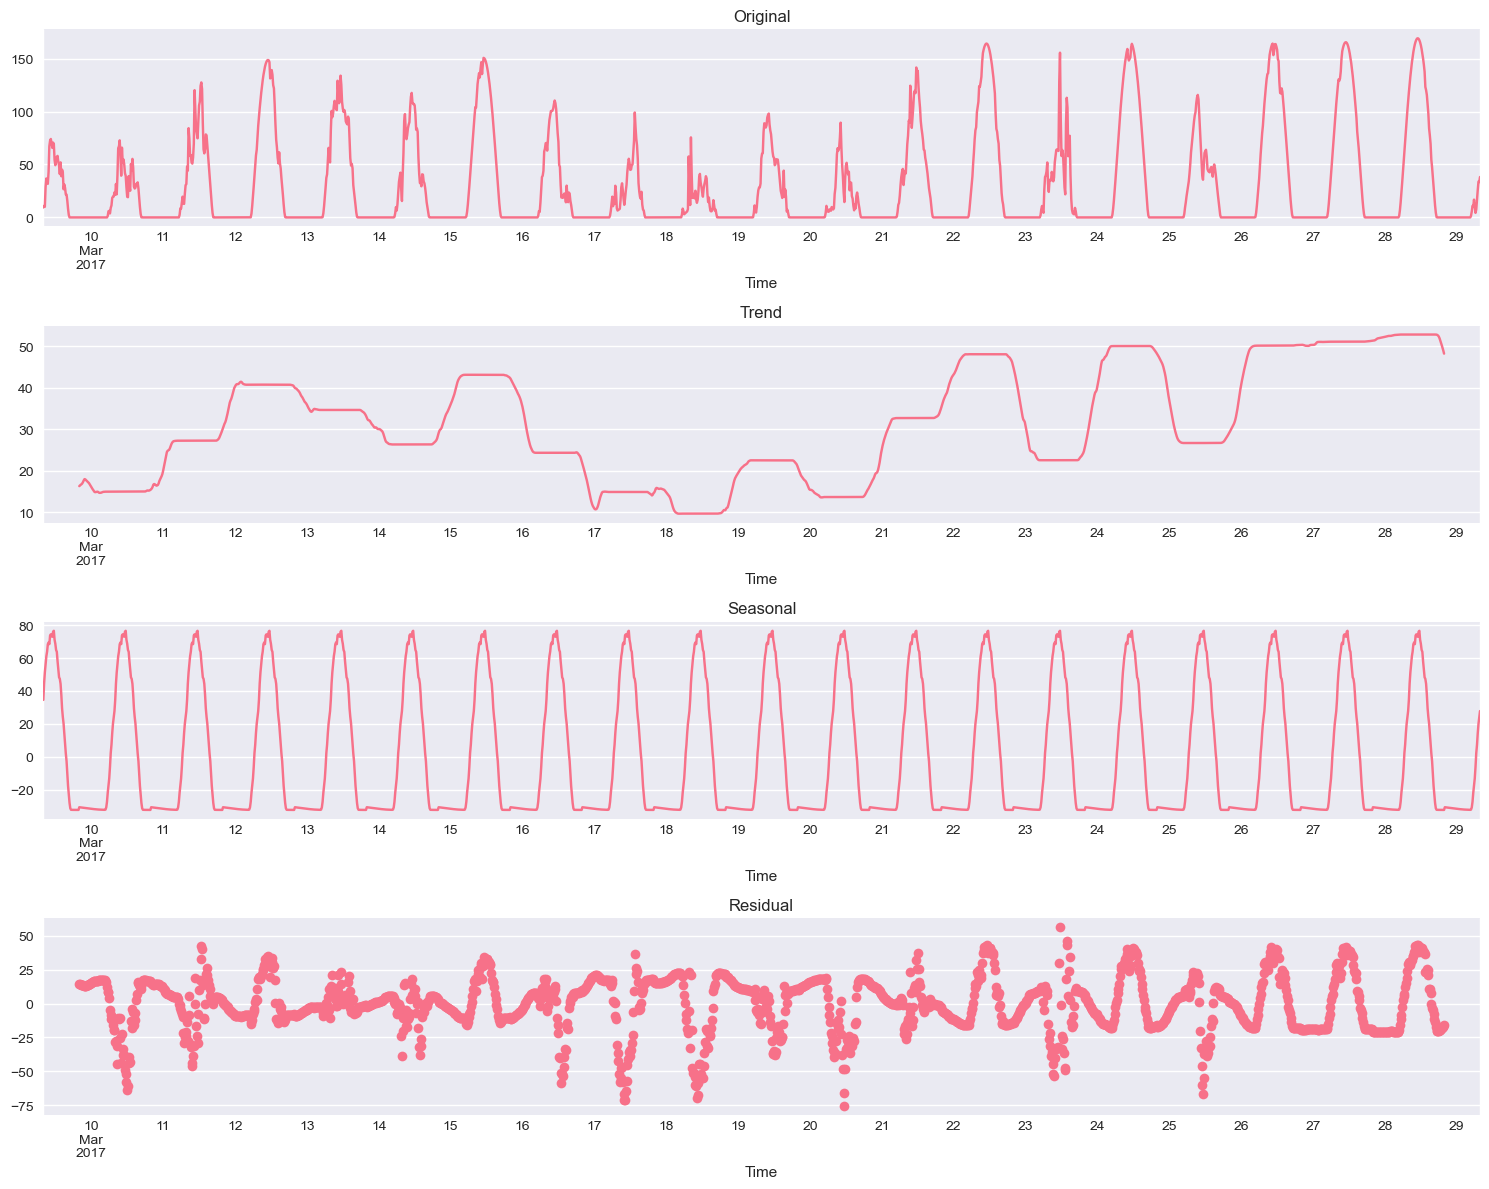

Seasonal decomposition completed


In [7]:
# Perform seasonal decomposition
print("Performing seasonal decomposition...")

try:
    # Use a subset for decomposition if data is too large
    decomp_data = train_series[-min(len(train_series), seasonality * 20):]
    
    decomposition = seasonal_decompose(
        decomp_data, 
        model='additive', 
        period=seasonality
    )
    
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    
    decomposition.observed.plot(ax=axes[0], title='Original')
    decomposition.trend.plot(ax=axes[1], title='Trend')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
    decomposition.resid.plot(ax=axes[3], title='Residual', marker="o", linestyle="none")
    
    plt.tight_layout()
    plt.show()
    
    print("Seasonal decomposition completed")
    
except Exception as e:
    print(f"Could not perform seasonal decomposition: {e}")

In [8]:


# Test original series
is_stationary = check_stationarity(train_series, "Original Training Series")


Stationarity Analysis for Original Training Series
ADF Test:
  Statistic: -14.910236
  p-value: 0.000000
  Critical Values: {'1%': -3.4311323596209617, '5%': -2.8618857489500686, '10%': -2.566954037311876}
  Result: Stationary

KPSS Test:
  Statistic: 4.669459
  p-value: 0.010000
  Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
  Result: Non-stationary

Consensus: Inconclusive


In [9]:
# If non-stationary, explore differencing
if not is_stationary:
    print("\nExploring differencing options...")
    
    # First difference
    train_diff1 = train_series.diff().dropna()
    is_stationary_diff1 = check_stationarity(train_diff1, "First Differenced Series")
    
    # Seasonal difference
    if len(train_series) > seasonality:
        train_seasonal_diff = train_series.diff(seasonality).dropna()
        is_stationary_seasonal = check_stationarity(train_seasonal_diff, "Seasonal Differenced Series")
        
        # Combined differencing
        train_combined_diff = train_series.diff().diff(seasonality).dropna()
        if len(train_combined_diff) > 50:
            is_stationary_combined = check_stationarity(train_combined_diff, "Combined Differenced Series")
    
    # Plot differenced series
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Original
    axes[0,0].plot(train_series.index[-500:], train_series[-500:])
    axes[0,0].set_title('Original Series (Last 500 points)')
    axes[0,0].grid(True, alpha=0.3)
    
    # First difference
    axes[0,1].plot(train_diff1.index[-500:], train_diff1[-500:])
    axes[0,1].set_title('First Differenced Series')
    axes[0,1].grid(True, alpha=0.3)
    
    # Seasonal difference
    if len(train_series) > seasonality:
        axes[1,0].plot(train_seasonal_diff.index[-500:], train_seasonal_diff[-500:])
        axes[1,0].set_title('Seasonal Differenced Series')
        axes[1,0].grid(True, alpha=0.3)
        
        # Combined
        axes[1,1].plot(train_combined_diff.index[-500:], train_combined_diff[-500:])
        axes[1,1].set_title('Combined Differenced Series')
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

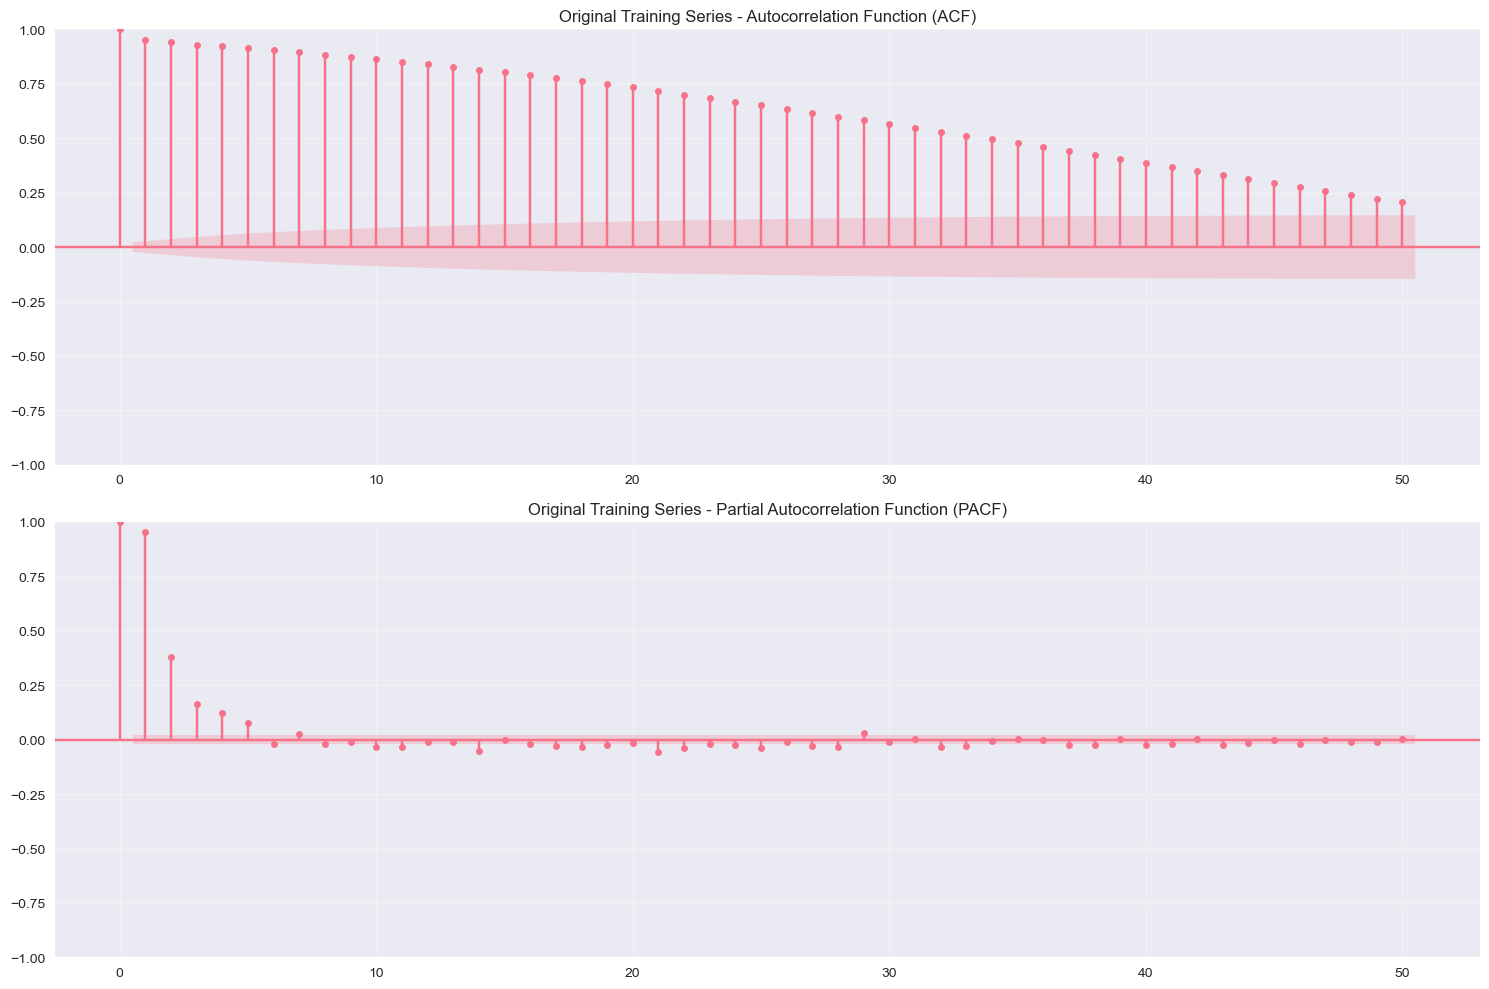


ACF/PACF Interpretation Guide:
AR(p): PACF cuts off after lag p, ACF decays slowly
MA(q): ACF cuts off after lag q, PACF decays slowly
ARMA(p,q): Both ACF and PACF decay slowly
Seasonal patterns repeat every 96 lags


In [ ]:


# Analyze original series
plot_acf_pacf_analysis(train_series, title="Original Training Series")

# Analyze differenced series if needed
if not is_stationary and 'train_diff1' in locals():
    plot_acf_pacf_analysis(train_diff1, title="First Differenced Series")

In [11]:
# Try automatic model selection first
print("SARIMA Model Selection")
print("=" * 40)

sarima_model = auto_sarima_selection(train_series, seasonality)

# If auto selection failed, try manual selection
if sarima_model is None:
    print("\nTrying manual SARIMA parameter selection...")
    
    # Based on stationarity analysis, choose appropriate parameters
    d = 0 if is_stationary else 1
    D = 1  # Usually 1 for seasonal data
    
    # Try several combinations
    param_combinations = [
        ((1, d, 1), (1, D, 1, seasonality)),
        ((2, d, 1), (1, D, 1, seasonality)),
        ((1, d, 2), (1, D, 1, seasonality)),
        ((2, d, 2), (1, D, 1, seasonality)),
        ((1, d, 1), (2, D, 1, seasonality)),
    ]
    
    best_aic = float('inf')
    best_model = None
    
    for order, seasonal_order in param_combinations:
        model = fit_sarima_model(train_series, order, seasonal_order)
        if model is not None:
            if model.aic < best_aic:
                best_aic = model.aic
                best_model = model
                print(f"   New best model: SARIMA{order} × {seasonal_order}, AIC: {model.aic:.2f}")
    
    sarima_model = best_model

# Display model summary
if sarima_model is not None:
    print(f"\nFinal SARIMA Model Summary:")
    print(sarima_model.summary())
else:
    print("Could not fit any SARIMA model")

SARIMA Model Selection
Running automatic SARIMA model selection (m=96)...
   Search space: max_p=1, max_q=1, max_P=1, max_Q=1, max_d=1, max_D=1
   Using conservative parameters to prevent kernel crashes...
   Using subset of 2000 points for model selection (full dataset: 8384)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[96] intercept   : AIC=13632.877, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[96] intercept   : AIC=13440.059, Time=149.92 sec
 ARIMA(0,1,1)(0,0,1)[96] intercept   : AIC=13422.020, Time=261.11 sec
 ARIMA(0,1,0)(0,0,0)[96]             : AIC=13630.877, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[96] intercept   : AIC=13431.205, Time=0.09 sec
 ARIMA(0,1,1)(1,0,1)[96] intercept   : AIC=inf, Time=795.61 sec


KeyboardInterrupt: 


Residual Diagnostics for SARIMA


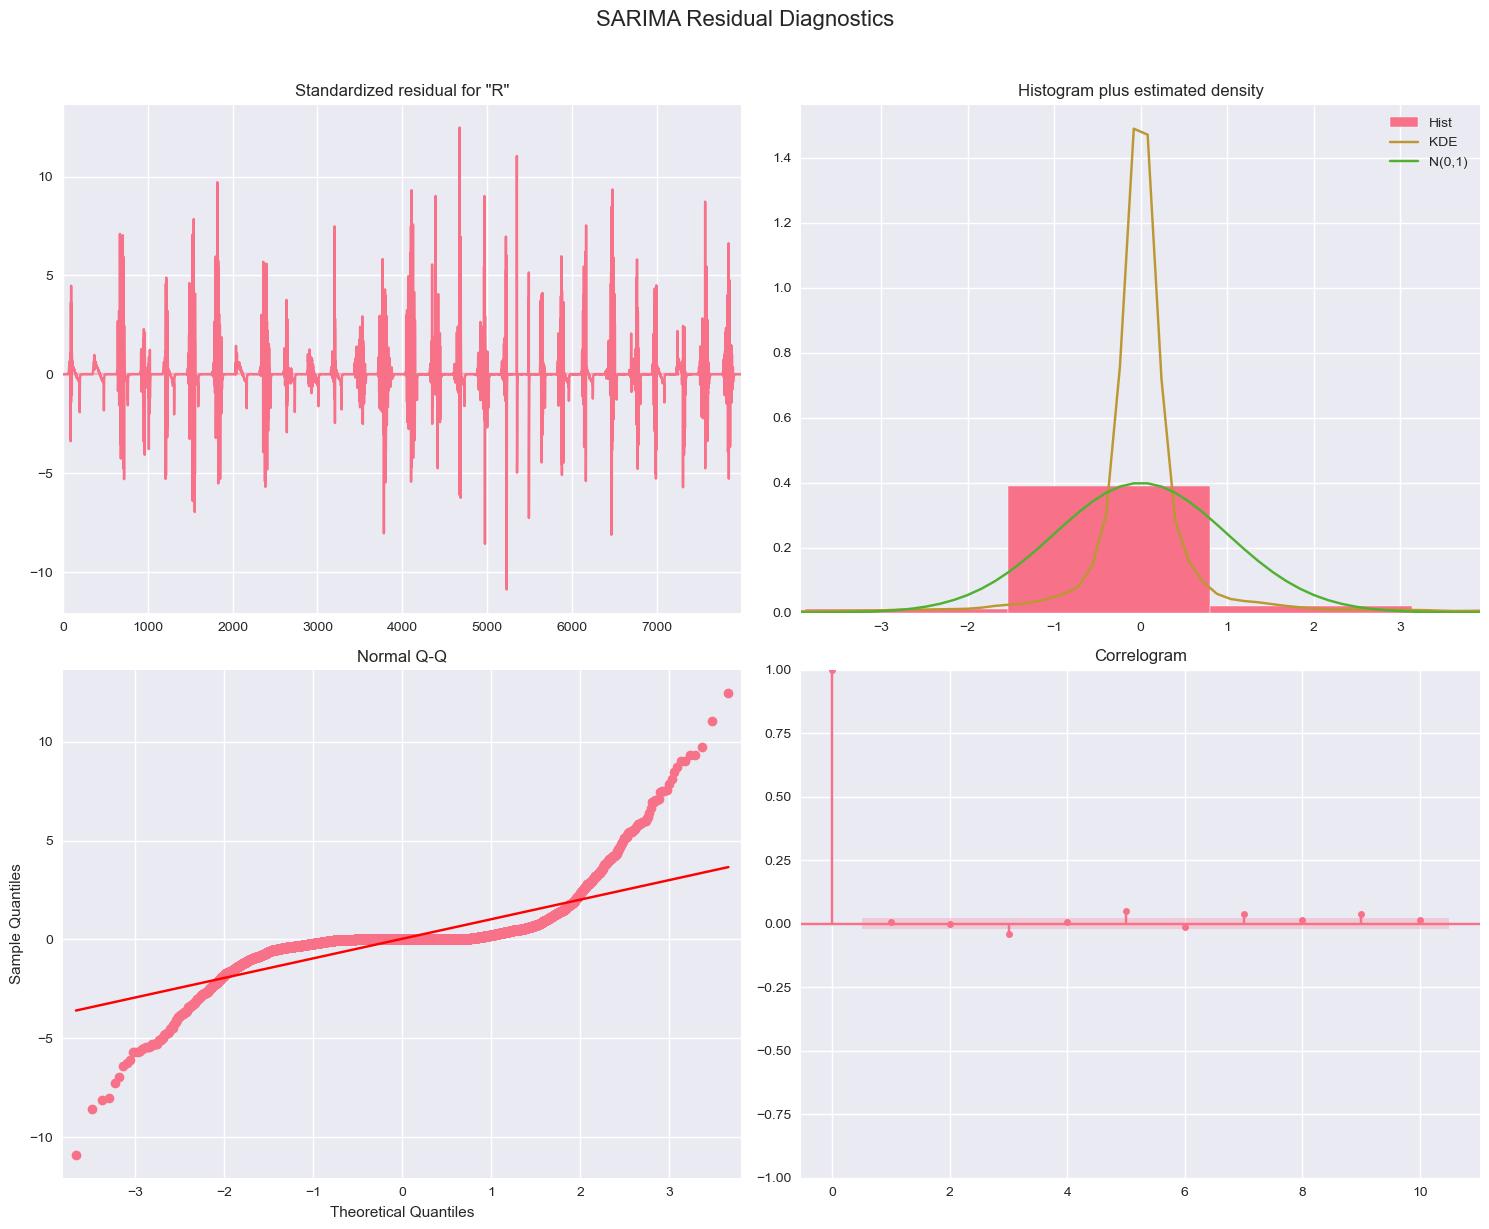

Ljung-Box Test Results (testing for autocorrelation):
       lb_stat     lb_pvalue
10   62.900918  1.019726e-09
20  128.186131  8.526105e-18
40  179.847507  1.220759e-19
Good: p-values > 0.05 (no significant autocorrelation)
Concerning: p-values ≤ 0.05 (autocorrelation present)

Jarque-Bera Normality Test:
p-value: 0.000000
Residuals may not be normally distributed

Residual Summary Statistics:
Mean: 3.136077 (should be close to 0)
Std: 94.496783
Skewness: 1.531996
Kurtosis: 29.036645


In [ ]:


# Perform diagnostics if model was fitted successfully
if sarima_model is not None:
    perform_residual_diagnostics(sarima_model, "SARIMA")

In [ ]:

# Fit ETS model
ets_model = select_best_ets_model(train_series, seasonality)

# Display model summary
if ets_model is not None:
    print(f"\nETS Model Summary:")
    print(ets_model.summary())
    
    # Perform diagnostics
    perform_residual_diagnostics(ets_model, "ETS")
else:
    print("Could not fit any ETS model")

ETS Model Selection

Fitting ETS(A,A,Ad) model...
Could not infer frequency, using original series
ETS model fitted successfully
   AIC: 95922.23
   BIC: 96641.91
   Log-likelihood: -47858.11

Fitting ETS(A,A,A) model...
Could not infer frequency, using original series
ETS model fitted successfully
   AIC: 95962.50
   BIC: 96675.19
   Log-likelihood: -47879.25

Fitting ETS(A,A,Md) model...
Could not infer frequency, using original series
ETS model fitted successfully
   AIC: 119089.06
   BIC: 119808.75
   Log-likelihood: -59441.53

Fitting ETS(A,A,M) model...
Could not infer frequency, using original series
ETS model fitted successfully
   AIC: 129731.18
   BIC: 130443.87
   Log-likelihood: -64763.59

Fitting ETS(A,N,A) model...
Could not infer frequency, using original series
ETS model fitted successfully
   AIC: 95941.96
   BIC: 96640.68
   Log-likelihood: -47870.98

Fitting ETS(A,N,M) model...
Could not infer frequency, using original series
ETS model fitted successfully
   AIC: 954

In [ ]:


# Create baseline models
baseline_predictions = create_baseline_models(train_series, test_series, seasonality)


Creating Baseline Models
Naive model created
Seasonal Naive model created
Linear Trend model created
Moving Average model created


In [16]:
# Collect all predictions
all_predictions = {}

# SARIMA predictions
if sarima_model is not None:
    try:
        print("\nGenerating SARIMA predictions...")
        sarima_forecast = sarima_model.forecast(steps=len(test_series))
        sarima_forecast.index = test_series.index
        all_predictions['SARIMA'] = sarima_forecast
        print("SARIMA predictions generated")
    except Exception as e:
        print(f"Error generating SARIMA predictions: {e}")

# ETS predictions
if ets_model is not None:
    try:
        print("Generating ETS predictions...")
        ets_forecast = ets_model.forecast(steps=len(test_series))
        ets_forecast.index = test_series.index
        all_predictions['ETS'] = ets_forecast
        print("ETS predictions generated")
    except Exception as e:
        print(f"Error generating ETS predictions: {e}")

# Add baseline predictions
all_predictions.update(baseline_predictions)

# Calculate comprehensive metrics
metrics_summary = create_metrics_summary(all_predictions, test_series)


Generating SARIMA predictions...
SARIMA predictions generated
Generating ETS predictions...
ETS predictions generated

Model Performance Evaluation

SARIMA:
  MAE:     238.8388
  RMSE:    411.7260
  MAPE:    96.15%
  R²:      -0.5074

ETS:
  MAE:     237.7339
  RMSE:    411.0464
  MAPE:    50.63%
  R²:      -0.5024

Naive:
  MAE:     237.7165
  RMSE:    411.0467
  MAPE:    49.41%
  R²:      -0.5024

Seasonal_Naive:
  MAE:     237.3451
  RMSE:    410.2036
  MAPE:    52.40%
  R²:      -0.4963

Linear_Trend:
  MAE:     392.0482
  RMSE:    450.6259
  MAPE:    76.47%
  R²:      -0.8057

Moving_Average:
  MAE:     237.7237
  RMSE:    409.9820
  MAPE:    97.37%
  R²:      -0.4947

Model Rankings (by RMSE):
            Model       MAE      RMSE     MAPE      R²
5  Moving_Average  237.7237  409.9820  97.3713 -0.4947
3  Seasonal_Naive  237.3450  410.2036  52.4027 -0.4963
1             ETS  237.7339  411.0464  50.6299 -0.5024
2           Naive  237.7165  411.0467  49.4087 -0.5024
0          SARI

In [ ]:


# Perform pairwise comparisons of top models
if metrics_summary is not None and len(metrics_summary) >= 2:
    print("\nStatistical Significance Testing (Diebold-Mariano)")
    print("=" * 60)
    
    top_models = metrics_summary.head(3)['Model'].values
    
    for i in range(len(top_models)):
        for j in range(i+1, len(top_models)):
            model1, model2 = top_models[i], top_models[j]
            
            if model1 in all_predictions and model2 in all_predictions:
                dm_stat, p_value = diebold_mariano_test(
                    test_series,
                    all_predictions[model1],
                    all_predictions[model2]
                )
                
                if dm_stat is not None:
                    significance = "Significant" if p_value < 0.05 else "Not Significant"
                    better_model = model1 if dm_stat < 0 else model2
                    
                    print(f"\n{model1} vs {model2}:")
                    print(f"  DM Statistic: {dm_stat:.4f}")
                    print(f"  p-value: {p_value:.4f}")
                    print(f"  Result: {significance}")
                    if p_value < 0.05:
                        print(f"  Better Model: {better_model}")


Statistical Significance Testing (Diebold-Mariano)

Moving_Average vs Seasonal_Naive:
  DM Statistic: -1.9147
  p-value: 0.0555
  Result: Not Significant

Moving_Average vs ETS:
  DM Statistic: -31.6540
  p-value: 0.0000
  Result: Significant
  Better Model: Moving_Average

Seasonal_Naive vs ETS:
  DM Statistic: -7.1726
  p-value: 0.0000
  Result: Significant
  Better Model: Seasonal_Naive


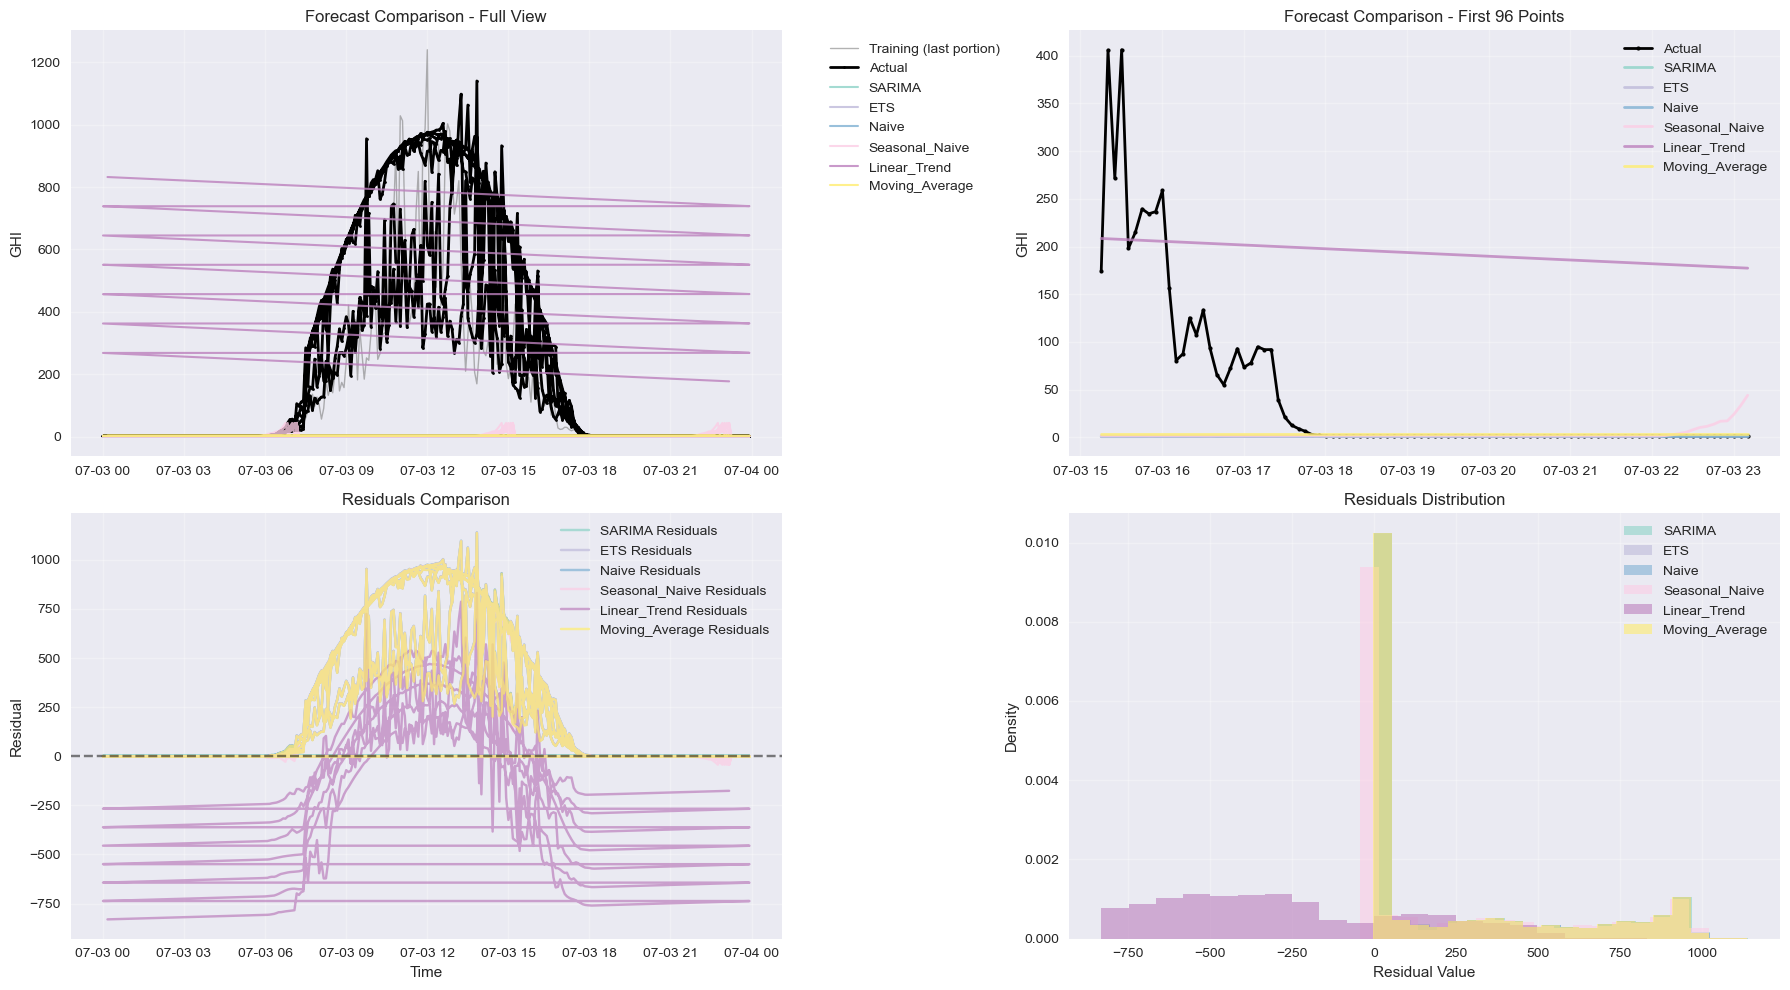

In [ ]:


# Create the comparison plot
plot_forecast_comparison(train_series, test_series, all_predictions)

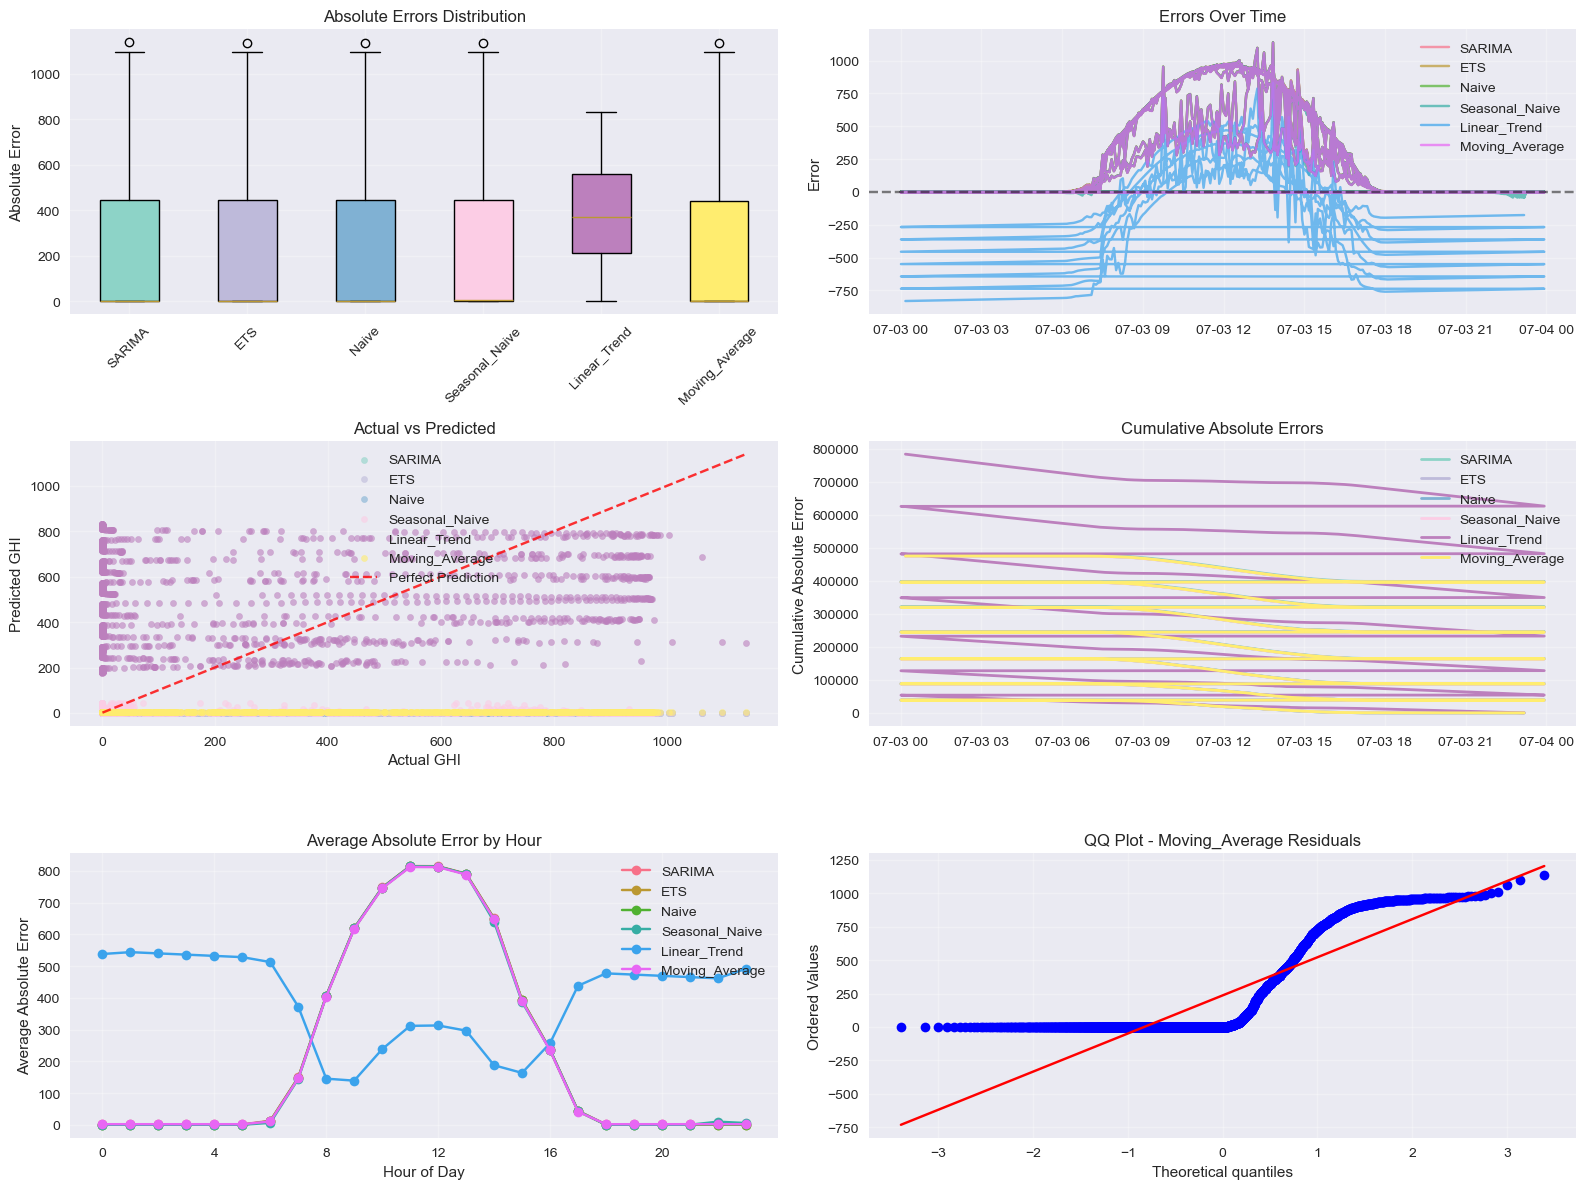

In [ ]:


# Create error analysis plots
plot_error_analysis(test_series, all_predictions)

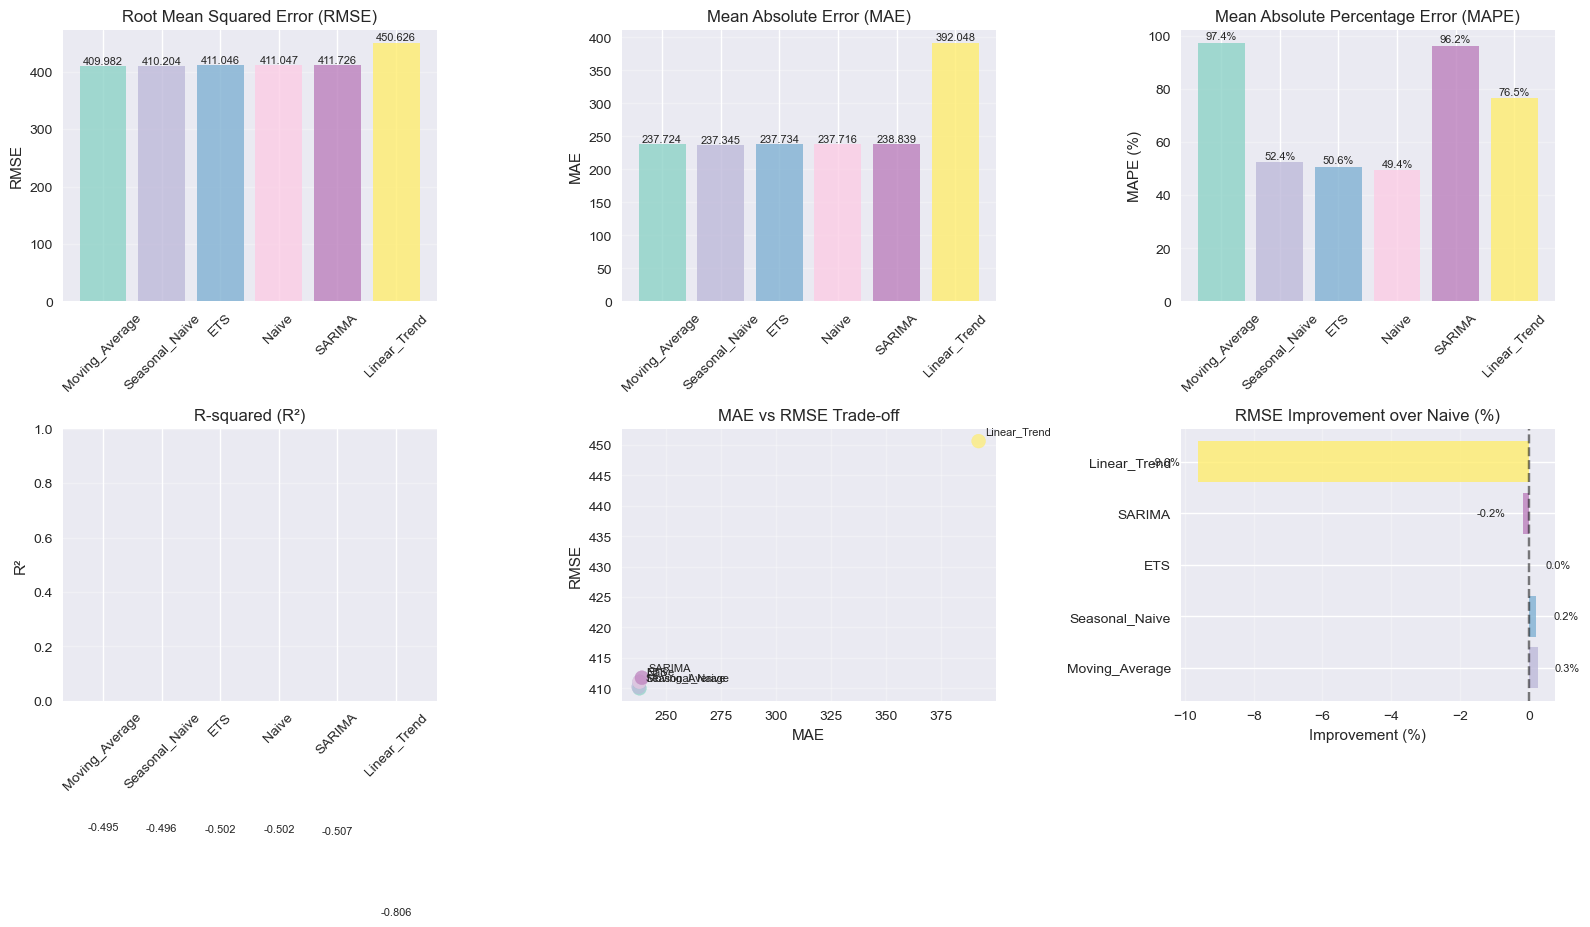

In [ ]:


# Create performance summary
create_performance_summary_plots(metrics_summary)